In [5]:
# # prompt: mount drive

# from google.colab import drive
# drive.mount('/content/drive')


In [6]:
!pip install mne

DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import os
import ntpath


import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from C:\Users\Malay\mne_data\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\654485358.py:14: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_train = mne.io.read_raw_edf(subject[0])
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\654485358.py:14: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_train = mne.io.read_raw_edf(subject[0])
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\654485358.py:14: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_train = mne.io.read_raw_edf(subject[0])
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\654485358.py:19: RuntimeWarning: The unit for channel(s) EMG submental, Event marker, Resp oro-nasal, Temp rectal has changed from V to NA.
  raw_train.set_channel_types(mapping) #mapeo de canales
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\654485358.py:22: RuntimeWarning: Loading an E

Using matplotlib as 2D backend.


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\654485358.py:22: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  raw_train.plot(duration=30,scalings='auto', start=300 ) #start = 0, inicio de registro - W


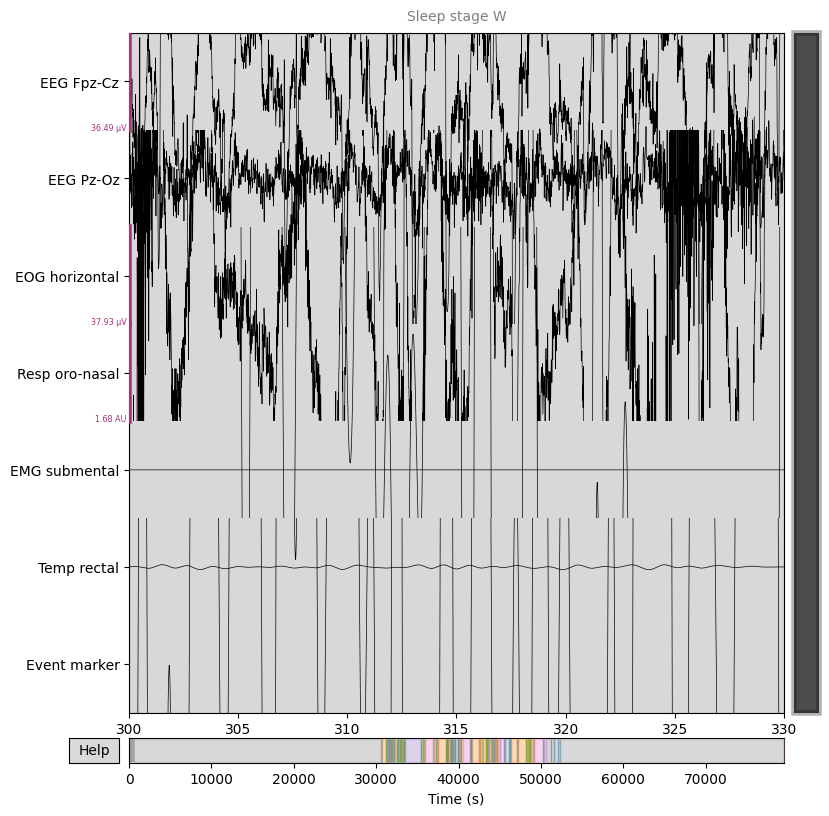

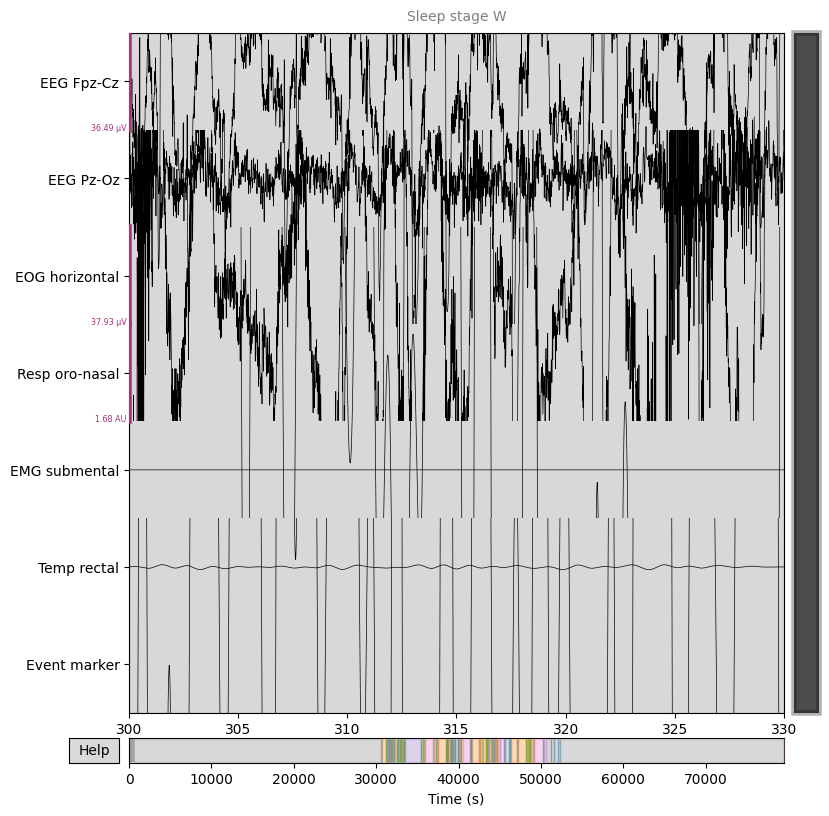

In [8]:
#fetching data for subject 0, recording 1
[subject] = fetch_data(subjects=[0], recording=[1] )


#Mapping of the channels
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}


# creating raw_train object with the *PSG.edf file of fetched data.
raw_train = mne.io.read_raw_edf(subject[0])

#The annot_train object has the annotations (labels) to be extracted from *Hypnogram.edf file of fetched data.
annot_train = mne.read_annotations(subject[1])
raw_train.set_annotations(annot_train, emit_warning=False)
raw_train.set_channel_types(mapping) #mapeo de canales

# plot some data
raw_train.plot(duration=30,scalings='auto', start=300 ) #start = 0, inicio de registro - W


In [9]:
#Each recording comes with metadata
print(raw_train.info)

#Sampling rate is an important variable
sampling_rate = raw_train.info['sfreq']

print('sampling_rate = {}'.format(sampling_rate))

<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 2 EEG, 1 EOG, 4 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
 subject_info: 4 items (dict)
>
sampling_rate = 100.0


In [10]:
# UTILS

# This classes and methods have been extracted from Supratak et al. (2017) paper and code.
  # Please review https://github.com/akaraspt/deepsleepnet for further detail.

import re, datetime, operator
import numpy as np
from collections import namedtuple
from builtins import str

EVENT_CHANNEL = 'EDF Annotations'

class EDFEndOfData(BaseException): pass

def tal(tal_str):
  '''Return a list with (onset, duration, annotation) tuples for an EDF+ TAL
  stream.
  '''
  exp = '(?P<onset>[+\-]\d+(?:\.\d*)?)' + \
    '(?:\x15(?P<duration>\d+(?:\.\d*)?))?' + \
    '(\x14(?P<annotation>[^\x00]*))?' + \
    '(?:\x14\x00)'

  def annotation_to_list(annotation):
    return annotation.split('\x14') if annotation else [] #str(annotation, 'latin_1')

  def parse(dic):
    return (
      float(dic['onset']),
      float(dic['duration']) if dic['duration'] else 0.,
      annotation_to_list(dic['annotation']))

  return [parse(m.groupdict()) for m in re.finditer(exp, tal_str)]


def edf_header(f):
  h = {}
  assert f.tell() == 0  # check file position
  assert f.read(8) == '0       '

  # recording info)
  h['local_subject_id'] = f.read(80).strip()
  h['local_recording_id'] = f.read(80).strip()

  # parse timestamp
  (day, month, year) = [int(x) for x in re.findall('(\d+)', f.read(8))]
  (hour, minute, sec)= [int(x) for x in re.findall('(\d+)', f.read(8))]
  h['date_time'] = str(datetime.datetime(year + 2000, month, day,
    hour, minute, sec))

  # misc
  header_nbytes = int(f.read(8))
  subtype = f.read(44)[:5]
  h['EDF+'] = subtype in ['EDF+C', 'EDF+D']
  h['contiguous'] = subtype != 'EDF+D'
  h['n_records'] = int(f.read(8))
  h['record_length'] = float(f.read(8))  # in seconds
  nchannels = h['n_channels'] = int(f.read(4))

  # read channel info
  channels = range(h['n_channels'])
  h['label'] = [f.read(16).strip() for n in channels]
  h['transducer_type'] = [f.read(80).strip() for n in channels]
  h['units'] = [f.read(8).strip() for n in channels]
  h['physical_min'] = np.asarray([float(f.read(8)) for n in channels])
  h['physical_max'] = np.asarray([float(f.read(8)) for n in channels])
  h['digital_min'] = np.asarray([float(f.read(8)) for n in channels])
  h['digital_max'] = np.asarray([float(f.read(8)) for n in channels])
  h['prefiltering'] = [f.read(80).strip() for n in channels]
  h['n_samples_per_record'] = [int(f.read(8)) for n in channels]
  f.read(32 * nchannels)  # reserved

  assert f.tell() == header_nbytes
  return h


class BaseEDFReader:
  def __init__(self, file):
    self.file = file


  def read_header(self):
    self.header = h = edf_header(self.file)

    # calculate ranges for rescaling
    self.dig_min = h['digital_min']
    self.phys_min = h['physical_min']
    phys_range = h['physical_max'] - h['physical_min']
    dig_range = h['digital_max'] - h['digital_min']
    assert np.all(phys_range > 0)
    assert np.all(dig_range > 0)
    self.gain = phys_range / dig_range


  def read_raw_record(self):
    '''Read a record with data and return a list containing arrays with raw
    bytes.
    '''
    result = []
    for nsamp in self.header['n_samples_per_record']:
      samples = self.file.read(nsamp * 2)
      if len(samples) != nsamp * 2:
        raise EDFEndOfData
      result.append(samples)
    return result


  def convert_record(self, raw_record):
    '''Convert a raw record to a (time, signals, events) tuple based on
    information in the header.
    '''
    h = self.header
    dig_min, phys_min, gain = self.dig_min, self.phys_min, self.gain
    time = float('nan')
    signals = []
    events = []
    for (i, samples) in enumerate(raw_record):
      if h['label'][i] == EVENT_CHANNEL:
        ann = tal(samples)
        time = ann[0][0]
        events.extend(ann[1:])
        # print(i, samples)
        # exit()
      else:
        # 2-byte little-endian integers
        dig = np.fromstring(samples, '<i2').astype(np.float32)
        phys = (dig - dig_min[i]) * gain[i] + phys_min[i]
        signals.append(phys)

    return time, signals, events


  def read_record(self):
    return self.convert_record(self.read_raw_record())


  def records(self):
    '''
    Record generator.
    '''
    try:
      while True:
        yield self.read_record()
    except EDFEndOfData:
      pass


def load_edf(edffile):
  '''Loexotic features like non-homogeneous sample rates and loading only parts of
  the stream, load_edf expects a single fixed sample rate for all channels and
  tries to load the wholead an EDF+ file.
  Very basic reader for EDF and EDF+ files. While BaseEDFReader does support
   file.
  Parameters
  ----------
  edffile : file-like object or string
  Returns
  -------
  Named tuple with the fields:
    X : NumPy array with shape p by n.
      Raw recording of n samples in p dimensions.
    sample_rate : float
      The sample rate of the recording. Note that mixed sample-rates are not
      supported.
    sens_lab : list of length p with strings
      The labels of the sensors used to record X.
    time : NumPy array with length n
      The time offset in the recording for each sample.
    annotations : a list with tuples
      EDF+ annotations are stored in (start, duration, description) tuples.
      start : float
        Indicates the start of the event in seconds.
      duration : float
        Indicates the duration of the event in seconds.
      description : list with strings
        Contains (multiple?) descriptions of the annotation event.
  '''
  if isinstance(edffile, basestring):
    with open(edffile, 'rb') as f:
      return load_edf(f)  # convert filename to file

  reader = BaseEDFReader(edffile)
  reader.read_header()

  h = reader.header

  # get sample rate info
  nsamp = np.unique(
    [n for (l, n) in zip(h['label'], h['n_samples_per_record'])
    if l != EVENT_CHANNEL])
  assert nsamp.size == 1, 'Multiple sample rates not supported!'
  sample_rate = float(nsamp[0]) / h['record_length']

  rectime, X, annotations = zip(*reader.records())
  X = np.hstack(X)
  annotations = reduce(operator.add, annotations)
  chan_lab = [lab for lab in reader.header['label'] if lab != EVENT_CHANNEL]

  # create timestamps
  if reader.header['contiguous']:
    time = np.arange(X.shape[1]) / sample_rate
  else:
    reclen = reader.header['record_length']
    within_rec_time = np.linspace(0, reclen, nsamp, endpoint=False)
    time = np.hstack([t + within_rec_time for t in rectime])

  tup = namedtuple('EDF', 'X sample_rate chan_lab time annotations')
  return tup(X, sample_rate, chan_lab, time, annotations)

In [11]:
import os
import numpy as np
from datetime import datetime as dt
from mne import io

# replace next variable (input_data_path) with your own path
input_data_path = '../npzla'

# list of your files
files = [('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4002E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4002EC-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4011E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4011EH-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4012E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4012EC-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4021E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4021EH-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4022E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4022EJ-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4031E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4031EC-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4032E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4032EP-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4041E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4041EC-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4042E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4042EC-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4051E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4051EC-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4052E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4052EC-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4061E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4061EC-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4062E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4062EC-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4071E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4071EC-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4072E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4072EH-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4081E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4081EC-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4082E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4082EP-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4091E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4091EC-Hypnogram.edf'),
    ('../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4092E0-PSG.edf', '../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4092EC-Hypnogram.edf'),]
for s1_files in files:
    select_ch = 'EEG Fpz-Cz'
    print('Files loaded: {} and {}'.format(s1_files[0], s1_files[1]))

    #We generate the object with signal data for each recording
    raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
    sampling_rate = raw.info['sfreq']
    raw_ch_df = raw.to_data_frame(scalings=100.0)[select_ch] #default="EEG Fpz-Cz",
    raw_ch_df = raw_ch_df.to_frame()
    raw_ch_df.set_index(np.arange(len(raw_ch_df)))

    # we obtain the recording's metadata, or header.
        # we obtain the recording's metadata, or header.
    f = open(s1_files[0], 'r', encoding = 'latin_1')
    reader_raw = BaseEDFReader(f)
    reader_raw.read_header()
    h_raw = reader_raw.header
    f.close()
    raw_start_dt = dt.strptime(h_raw['date_time'], "%Y-%m-%d %H:%M:%S")

    f = open(s1_files[1], 'r')
    reader_ann = BaseEDFReader(f)
    reader_ann.read_header()
    h_ann = reader_ann.header

    _, _, ann = zip(*reader_ann.records())
    f.close()
    ann_start_dt = dt.strptime(h_ann['date_time'], "%Y-%m-%d %H:%M:%S")

    assert raw_start_dt == ann_start_dt

    # Label values
    W = 0
    N1 = 1
    N2 = 2
    N3 = 3
    REM = 4
    UNKNOWN = 5

    stage_dict = { "W": W, "N1": N1, "N2": N2, "N3": N3, "REM": REM, "UNKNOWN": UNKNOWN }
    class_dict = { 0: "W", 1: "N1", 2: "N2", 3: "N3", 4: "REM", 5: "UNKNOWN" }
    ann2label = {  "Sleep stage W": 0, "Sleep stage 1": 1, "Sleep stage 2": 2, "Sleep stage 3": 3,
             "Sleep stage 4": 3, "Sleep stage R": 4, "Sleep stage ?": 5, "Movement time": 5 }
    EPOCH_SEC_SIZE = 30

    # Vector with indices and labels
    remove_idx = []    # indicies of the data that will be removed
    labels = []        # indicies of the data that have labels
    label_idx = []
    for a in ann[0]:
      onset_sec, duration_sec, ann_char = a
      ann_str = "".join(ann_char)
      label = ann2label[ann_str]
      if label != UNKNOWN:
        if duration_sec % EPOCH_SEC_SIZE != 0:
          raise Exception("Something wrong")
        duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
        label_epoch = np.ones(duration_epoch, dtype=np.int64) * label
        labels.append(label_epoch)
        idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=int)
        label_idx.append(idx)

      else:
        idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=int)
        remove_idx.append(idx)

    labels = np.hstack(labels)

    if len(remove_idx) > 0:
      remove_idx = np.hstack(remove_idx)
      select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
    else:
      select_idx = np.arange(len(raw_ch_df))

    # Only valid labels
    label_idx = np.hstack(label_idx)
    select_idx = np.intersect1d(select_idx, label_idx)

    # If necessary, extra indices are removed
    if len(label_idx) > len(select_idx):
        extra_idx = np.setdiff1d(label_idx, select_idx)
        # Vector tail is trimmed
        if np.all(extra_idx > select_idx[-1]):
            n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
            n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
            select_idx = select_idx[:-n_trims]
            labels = labels[:-n_label_trims]

    raw_ch = raw_ch_df.values[select_idx]

    # Vector should be splittable into 30 second periods
    if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
        raise Exception("Something wrong")
    n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

    x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
    y = labels.astype(np.int32)

    assert len(x) == len(y)

    # We keep only section that correspond to sleep.
    w_edge_mins = 30
    nw_idx = np.where(y != stage_dict["W"])[0]
    start_idx = nw_idx[0] - (w_edge_mins * 2) #60  epochs before sleep onset
    end_idx = nw_idx[-1] + (w_edge_mins * 2) # 60 epochs after sleep is finished
    if start_idx < 0: start_idx = 0
    if end_idx >= len(y): end_idx = len(y) - 1
    select2_idx = np.arange(start_idx, end_idx+1)
    raw_datapoint = x.shape[0]
    x = x[select2_idx]
    selected_datapoints = x.shape[0]
    y = y[select2_idx]
    cal =  (raw_datapoint - selected_datapoints )*100/raw_datapoint

    filename = ntpath.basename(s1_files[0]).replace("-PSG.edf", ".npz")
    save_dict = {
        "x": x,
        "y": y,
        "fs": sampling_rate,
        "ch_label": select_ch,
        "header_raw": h_raw,
        "header_annotation": h_ann,
    }

    np.savez(os.path.join(input_data_path, filename), **save_dict)

    print('File {} was processed and saved'.format(s1_files[0]))

    print("\n=======================================\n")

Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4002E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4002EC-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4002E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4011E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4011EH-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4011E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4012E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4012EC-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8549999  =      0.000 ... 85499.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4012E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4021E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4021EH-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8411999  =      0.000 ... 84119.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4021E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4022E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4022EJ-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4022E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8267999  =      0.000 ... 82679.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4022E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4031E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4031EC-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8459999  =      0.000 ... 84599.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4031E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4032E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4032EP-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4032E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8195999  =      0.000 ... 81959.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4032E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4041E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4041EC-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7709999  =      0.000 ... 77099.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4041E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4042E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4042EC-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4042E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8375999  =      0.000 ... 83759.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4042E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4051E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4051EC-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4051E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8165999  =      0.000 ... 81659.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4051E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4052E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4052EC-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4052E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8417999  =      0.000 ... 84179.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4052E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4061E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4061EC-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4061E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8309999  =      0.000 ... 83099.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4061E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4062E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4062EC-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4062E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4062E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4071E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4071EC-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4071E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4071E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4072E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4072EH-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4072E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8309999  =      0.000 ... 83099.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4072E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4081E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4081EC-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4081E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8387999  =      0.000 ... 83879.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4081E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4082E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4082EP-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4082E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7901999  =      0.000 ... 79019.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4082E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4091E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4091EC-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4091E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8195999  =      0.000 ... 81959.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4091E0-PSG.edf was processed and saved


Files loaded: ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4092E0-PSG.edf and ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4092EC-Hypnogram.edf
Extracting EDF parameters from c:\Users\Malay\Desktop\Minor\data_set\sleeping_dataset\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4092E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8573999  =      0.000 ... 85739.990 secs...


C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)
C:\Users\Malay\AppData\Local\Temp\ipykernel_9720\3591373909.py:35: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = io.read_raw_edf(s1_files[0], preload=True, stim_channel=None)


File ../data_set/sleeping_dataset/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4092E0-PSG.edf was processed and saved




In [12]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time
from datetime import datetime as dt
import pandas as pd
import os
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import Normalizer




#Functions

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

def _load_npz_file(npz_file):
    """Load data and labels from a npz file."""
    with np.load(npz_file) as f:
        data = f["x"]
        labels = f["y"]
        sampling_rate = f["fs"]
    return data, labels, sampling_rate

def _load_npz_list_files(npz_files):
    """Load data and labels from list of npz files."""
    data = []
    labels = []
    fs = None
    for npz_f in npz_files:
        tmp_data, tmp_labels, sampling_rate = _load_npz_file(npz_f)
        if fs is None:
            fs = sampling_rate
        elif fs != sampling_rate:
            raise Exception("Found mismatch in sampling rate.")
        data.append(tmp_data)
        labels.append(tmp_labels)
    data = np.vstack(data)
    labels = np.hstack(labels)
    return data, labels

In [23]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from keras.regularizers import l2

# # Check TensorFlow version (ensures TensorFlow 2.x)
# print("TensorFlow version:", tf.__version__)

# # Check if GPU is available
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     print("Num GPUs Available: ", len(gpus))
#     print("GPU is available. Checking GPU details...")
    
#     # Set memory growth on the GPU to prevent TensorFlow from allocating all GPU memory
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
    
#     # Test if TensorFlow is using the GPU
#     device_name = tf.test.gpu_device_name()
#     if device_name:
#         print('Found GPU at: {}'.format(device_name))
#     else:
#         print("GPU found but not configured correctly.")
# else:
#     raise SystemError('GPU device not found')


TensorFlow version: 2.17.0


SystemError: GPU device not found

In [24]:
# Load npz files

# Change variable 'path' with own path

path = '../NPZ/' #the path where the npz files were saved in the first notebook.

# path = '/content/gdrive/My Drive/Tesis/Código/Data_nuevodp'

files = os.listdir(path)
filespath = []
for i in files:
  filespath.append(os.path.join(path,i))

X, Y = _load_npz_list_files(filespath)

X = X.reshape((X.shape[0], X.shape[1], 1))
print(X.shape, Y.shape)

(42080, 3000, 1) (42080,)


In [25]:
CNN_CONCAT = 'CNN_CONCAT'

In [39]:
def cnn_builder(model_type):
    '''function that sets the CNN layers from input to keras.Model'''

    input_length = 15000 if model_type == 'CNN_CONCAT' else 3000

    inputs = keras.Input(shape=(input_length, 1))

    # Left leg - short filters
    x = layers.Conv1D(filters=64, kernel_size=50, strides=6, name='conv1')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPool1D(pool_size=8, strides=8, name='max1')(x)
    x = layers.Dropout(rate=0.5, name='dropout1')(x)

    x = layers.Conv1D(filters=128, kernel_size=8, strides=1, name='conv2', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv1D(filters=128, kernel_size=8, strides=1, name='conv3', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv1D(filters=128, kernel_size=8, strides=1, name='conv4', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPool1D(pool_size=4, strides=4, name='max2')(x)
    x = layers.Flatten()(x)

    # Right leg - longer filters
    x2 = layers.Conv1D(filters=64, kernel_size=400, strides=50, name='conv1_2')(inputs)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.ReLU()(x2)

    x2 = layers.MaxPool1D(pool_size=4, strides=4, name='max1_2')(x2)
    x2 = layers.Dropout(rate=0.5, name='dropout1_2')(x2)

    x2 = layers.Conv1D(filters=128, kernel_size=6, strides=1, name='conv2_2', padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.ReLU()(x2)

    x2 = layers.Conv1D(filters=128, kernel_size=6, strides=1, name='conv3_2', padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.ReLU()(x2)

    x2 = layers.Conv1D(filters=128, kernel_size=6, strides=1, name='conv4_2', padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.ReLU()(x2)

    x2 = layers.MaxPool1D(pool_size=2, strides=2, name='max2_2')(x2)
    x2 = layers.Flatten()(x2)

    # Concatenate both legs
    concat = layers.Concatenate(name='concat')([x, x2])

    # Final layer as softmax
    outputs = layers.Dense(5, activation=tf.nn.softmax, name='soft')(concat)

    model = keras.Model(inputs=inputs, outputs=outputs, name='sleep')

    # Print the model architecture
    model.summary()

    return model

# To build and print the model
cnn_model = cnn_builder('CNN_CONCAT')


Model: "sleep"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 15000, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv1D)      │ (None, 2492, 64)  │      3,264 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_2 (Conv1D)    │ (None, 293, 64)   │     25,664 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2492, 64)  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 293, 64)   │        256 │ conv1_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_40 (ReLU)     │ (None, 2492, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_44 (ReLU)     │ (None, 293, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max1 (MaxPooling1D) │ (None, 311, 64)   │          0 │ re_lu_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max1_2              │ (None, 73, 64)    │          0 │ re_lu_44[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 311, 64)   │          0 │ max1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1_2          │ (None, 73, 64)    │          0 │ max1_2[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv1D)      │ (None, 311, 128)  │     65,664 │ dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2 (Conv1D)    │ (None, 73, 128)   │     49,280 │ dropout1_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 311, 128)  │        512 │ conv2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 128)   │        512 │ conv2_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_41 (ReLU)     │ (None, 311, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_45 (ReLU)     │ (None, 73, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv1D)      │ (None, 311, 128)  │    131,200 │ re_lu_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_2 (Conv1D)    │ (None, 73, 128)   │     98,432 │ re_lu_45[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 311, 128)  │        512 │ conv3[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 128)   │        512 │ conv3_2[0][0]   

 Total params: 679,045 (2.59 MB)

 Trainable params: 677,253 (2.58 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [37]:
print(model)

<Functional name=sleep, built=True>


In [38]:
def lstm_builder():
    inputs = keras.Input(shape=(5, 2688))

    x = layers.Dropout(rate=0.5, name='lstm_dropout1')(inputs)

    x1 = Bidirectional(layers.LSTM(512, return_sequences=True))(x)
    x1 = layers.Dropout(rate=0.5, name='lstm_dropout2')(x1)

    x1 = Bidirectional(layers.LSTM(512))(x1)
    x1 = layers.Dropout(rate=0.5, name='lstm_dropout3')(x1)

    x2 = layers.Dense(1024)(x)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.ReLU(name='lstm_residual1')(x2)

    addition = layers.Add(name='lstm_concat1')([x1, x2])

    x3 = layers.BatchNormalization()(addition)
    x3 = layers.ReLU(name='lstm_residual2')(x3)

    x3 = layers.Dropout(rate=0.5, name='lstm_dropout4')(x3)

    x3 = layers.Flatten()(x3)

    outputs = layers.Dense(5, activation=tf.nn.softmax, name='lstm_soft')(x3)

    model_lstm = keras.Model(inputs=inputs, outputs=outputs, name='lstmsleep')

    # Print the model architecture
    model_lstm.summary()

    return model_lstm

# To build and print the model
lstm_model = lstm_builder()


Model: "lstmsleep"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 5, 2688)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout1       │ (None, 5, 2688)   │          0 │ input_layer_10[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 5, 1024)   │ 13,111,296 │ lstm_dropout1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout2       │ (None, 5, 1024)   │          0 │ bidirectional_10… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 5, 1024)   │  2,753,536 │ lstm_dropout1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 1024)      │  6,295,552 │ lstm_dropout2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 1024)   │      4,096 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout3       │ (None, 1024)      │          0 │ bidirectional_11… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_residual1      │ (None, 5, 1024)   │          0 │ batch_normalizat… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_concat1 (Add)  │ (None, 5, 1024)   │          0 │ lstm_dropout3[0]… │
│                     │                   │            │ lstm_residual1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 1024)   │      4,096 │ lstm_concat1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_residual2      │ (None, 5, 1024)   │          0 │ batch_normalizat… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout4       │ (None, 5, 1024)   │          0 │ lstm_residual2[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 5120)      │          0 │ lstm_dropout4[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_soft (Dense)   │ (None, 5)         │     25,605 │ flatten_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,194,181 (84.66 MB)

 Trainable params: 22,190,085 (84.65 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [28]:
from tensorflow.keras.layers import Bidirectional #we will be needing this layer


# perform training and prediction for 20 stratified folds


skf = StratifiedKFold(n_splits=5) #10 - 20

cv_results = []
k = 0
for train_index,test_index in skf.split(X, Y):
  begin_time_loop = dt.now()
  print('Current time: {}'.format(str(begin_time_loop)))

  k = k+1
  X_train,X_test=X[train_index],X[test_index]
  y_train,y_test=Y[train_index],Y[test_index] 

  #CNN
  model = cnn_builder( model_type = 'CNN+LSTM')

  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

  history1 = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=19, verbose=0) # 24


  #get feature vectors
  layer_name = 'concat'
  intermediate_layer_model = keras.Model(inputs=model.input,
                                  outputs=model.get_layer(layer_name).output)
  intermediate_output_train = intermediate_layer_model.predict(X_train)
  intermediate_output_test = intermediate_layer_model.predict(X_test)
  X_train_lstm = intermediate_output_train
  X_test_lstm = intermediate_output_test

  a = np.zeros((1, 2688))

  X_train_lstm = np.insert(X_train_lstm, 0, a, axis=0)
  X_train_lstm = np.insert(X_train_lstm, 0, a, axis=0)
  X_train_lstm = np.insert(X_train_lstm, -1, a, axis=0)
  X_train_lstm = np.insert(X_train_lstm, -1, a, axis=0)

  X_test_lstm = np.insert(X_test_lstm, 0, a, axis=0)
  X_test_lstm = np.insert(X_test_lstm, 0, a, axis=0)
  X_test_lstm = np.insert(X_test_lstm, -1, a, axis=0)
  X_test_lstm = np.insert(X_test_lstm, -1, a, axis=0)

  X_train_lstm2 = []
  for i in range(len(X_train_lstm)-4):
    j = i + 2
    clip = np.array([X_train_lstm[j-2], X_train_lstm[j-1], X_train_lstm[j], X_train_lstm[j+1], X_train_lstm[j+2]])
    X_train_lstm2.append(clip)

  X_test_lstm2 = []
  for i in range(len(X_test_lstm)-4):
    j = i + 2
    clip = np.array([X_test_lstm[j-2], X_test_lstm[j-1], X_test_lstm[j], X_test_lstm[j+1], X_test_lstm[j+2]])
    X_test_lstm2.append(clip)

  X_train_lstm3=np.array(X_train_lstm2)
  X_test_lstm3=np.array(X_test_lstm2)

  #LSTM
  lstm = lstm_builder()

  lstm.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

  history2 = lstm.fit(X_train_lstm3, y_train,
                      batch_size=64,
                      epochs=5, verbose=0) #

  test_scores = lstm.evaluate(X_test_lstm3, y_test, verbose=0)
  print('Test accuracy:', test_scores[1])

  y_prob = lstm.predict(X_test_lstm3)

  y_pred = y_prob.argmax(axis=-1)

  elapsed = dt.now() - begin_time_loop
  print('Fold {} took {}'.format(str(k), str(elapsed)))

  fold_result = {'fold': k, 'time': elapsed,'y_test': y_test, 'y_pred': y_pred, 'y_prob': y_prob,
               'history_cnn': history1.history, 'history_lstm': history2.history,  'accuracy': test_scores[1] }


  cv_results.append(fold_result)

Current time: 2024-10-06 10:04:19.280293
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
Test accuracy: 0.8577709197998047
263/263 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step
Fold 1 took 1:16:40.990816
Current time: 2024-10-06 11:21:00.277112
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
Test accuracy: 0.8543251156806946
263/263 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step
Fold 2 took 1:18:39.447775
Current time: 2024-10-06 12:39:39.733883
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Test accuracy: 0.8722671270370483
263/263 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step
Fold 3 took 1:17:02.912365
Current time: 2024-10-06 13:56:42.661245
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
Test accuracy: 0.8307985067367554
263/263 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step
Fold 4 took 1:16:42.801886
Current time: 2024-10-06 15:13:25.473130
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 

In [29]:


# unravel y_pred and y_test into unique vectors for classification report
y_pred=[]
y_test=[]
for i in cv_results:
  y_pred.extend(i['y_pred'])
  y_test.extend(i['y_test'])


print(classification_report(y_test,y_pred, digits=2) )

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      7314
           1       0.57      0.49      0.52      3378
           2       0.95      0.86      0.90     17854
           3       0.87      0.97      0.92      6148
           4       0.75      0.89      0.81      7386

    accuracy                           0.86     42080
   macro avg       0.80      0.82      0.81     42080
weighted avg       0.86      0.86      0.86     42080



In [42]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming cv_results is defined and contains the necessary predictions
y_pred = []
y_test = []

# Unravel y_pred and y_test into unique vectors for classification report
for i in cv_results:
    y_pred.extend(i['y_pred'])
    y_test.extend(i['y_test'])

# Generate the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the metrics into percentages
for label, metrics in report.items():
    if label != 'accuracy':
        metrics['precision'] = round(metrics['precision'] * 100, 2)  # Convert precision to percentage
        metrics['recall'] = round(metrics['recall'] * 100, 2)        # Convert recall to percentage
        metrics['f1-score'] = round(metrics['f1-score'] * 100, 2)    # Convert F1-score to percentage
        metrics['support'] = int(metrics['support'])                  # Keep support as integer

# Display the modified report
print("Classification Report (Percentage Values):")
print("-------------------------------------------------")
print("Label\t\tPrecision\tRecall\t\tF1-Score\tSupport")
for label, metrics in report.items():
    if label != 'accuracy':
        print(f"{label}\t\t{metrics['precision']}%\t\t{metrics['recall']}%\t\t{metrics['f1-score']}%\t\t{metrics['support']}")
print("-------------------------------------------------")
print(f"Accuracy:\t{round(report['accuracy'] * 100, 2)}%")


Classification Report (Percentage Values):
-------------------------------------------------
Label		Precision	Recall		F1-Score	Support
0		88.29%		89.99%		89.13%		7314
1		56.64%		48.85%		52.46%		3378
2		94.72%		85.58%		89.92%		17854
3		86.94%		96.99%		91.69%		6148
4		75.13%		88.72%		81.36%		7386
macro avg		80.34%		82.03%		80.91%		42080
weighted avg		85.97%		85.62%		85.53%		42080
-------------------------------------------------
Accuracy:	85.62%


Text(0.5, 47.7222222222222, 'Predicted labels')

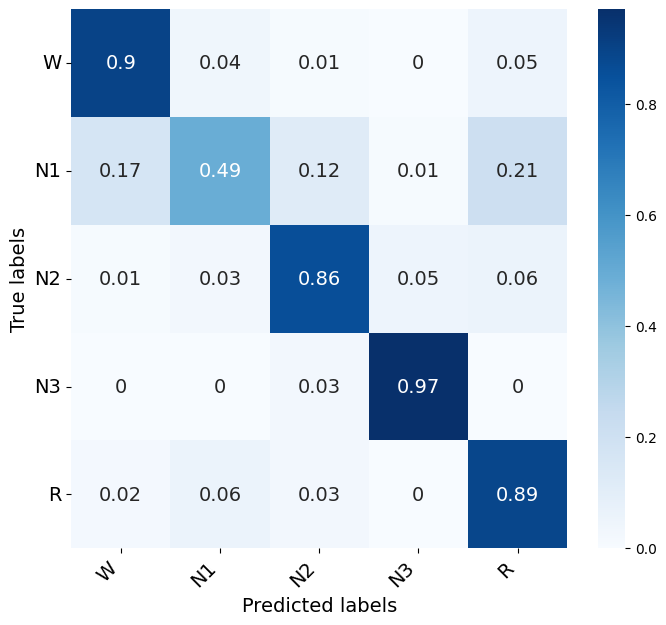

In [31]:
# print confusion matrix

C = confusion_matrix( y_test ,y_pred)
cn = np.transpose( np.transpose(C) / C.astype(float).sum(axis=1) )
cn = np.round(cn, 2)

df_cm = pd.DataFrame(
    cn, index=['W','N1','N2','N3','R'], columns=['W','N1','N2','N3','R'])
fig = plt.figure(figsize=(8,7))
try:
    heatmap = sns.heatmap(df_cm, annot=True, cmap = "Blues", annot_kws={"size": 14})
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True labels', fontsize = 14)
plt.xlabel('Predicted labels',  fontsize=14)


Text(0.5, 47.7222222222222, 'Predicted labels')

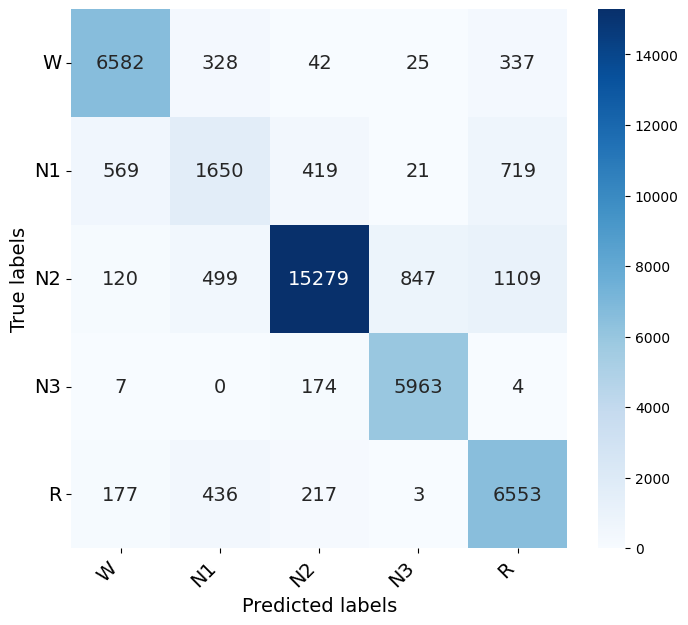

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C = confusion_matrix( y_test ,y_pred)

df_cm = pd.DataFrame(C, index=['W','N1','N2','N3','R'], columns=['W','N1','N2','N3','R'])

fig = plt.figure(figsize=(8,7))
try:
    heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 14})
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True labels', fontsize = 14)
plt.xlabel('Predicted labels',  fontsize=14)


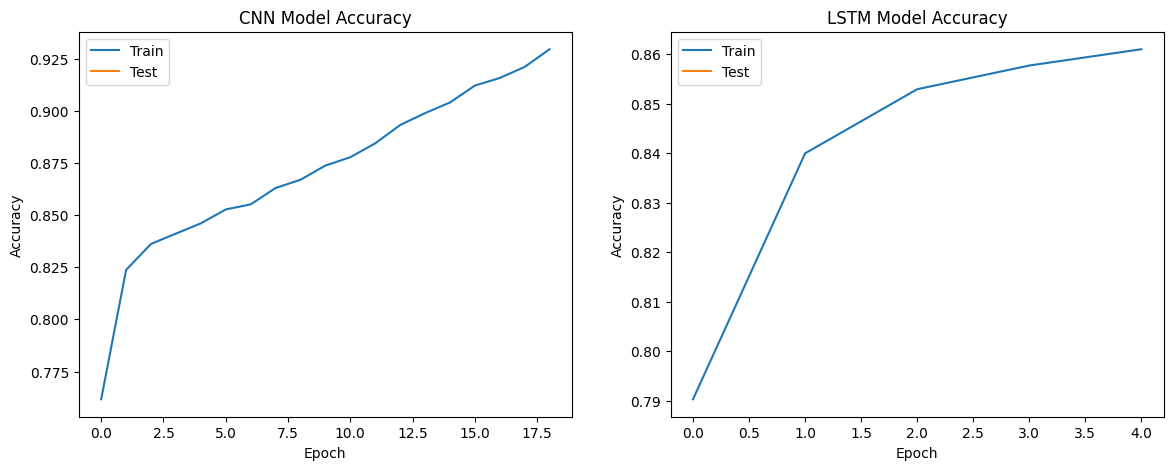

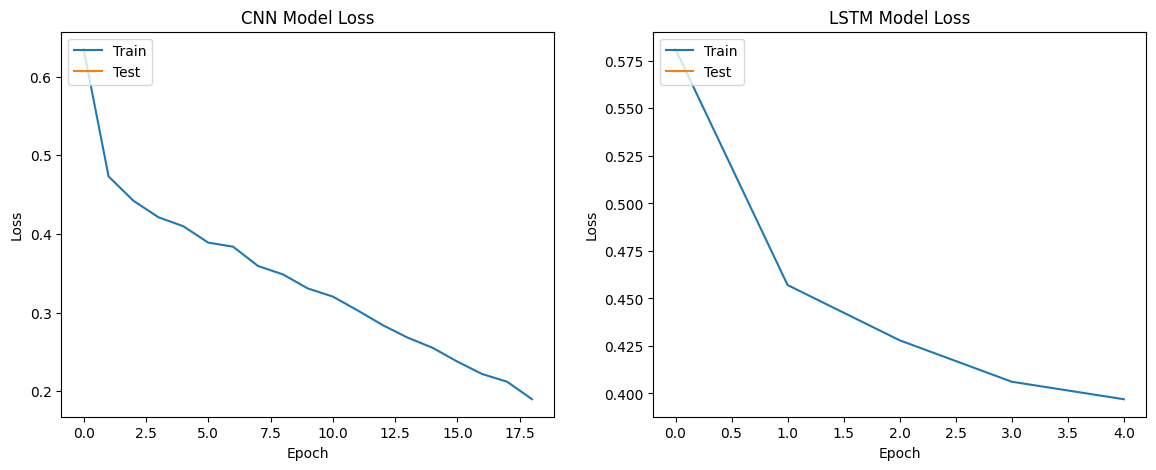

In [33]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history.get('val_accuracy', []))  # Include if validation accuracy was calculated
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history.get('val_accuracy', []))  # Include if validation accuracy was calculated
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'])
plt.plot(history1.history.get('val_loss', []))  # Include if validation loss was calculated
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history.get('val_loss', []))  # Include if validation loss was calculated
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


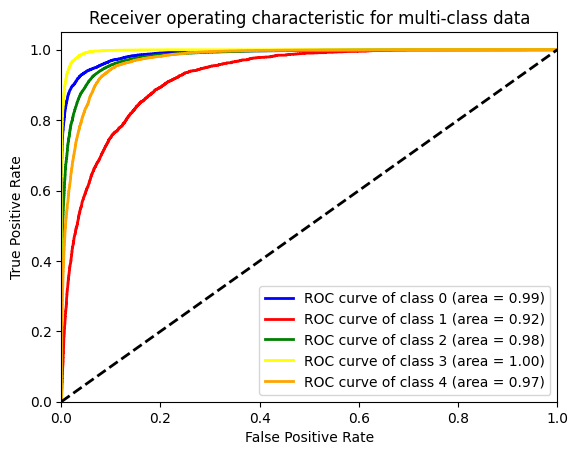

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from itertools import cycle

# Assume 'y_test' are your observed labels and that `cv_results` hold the `y_prob` from each fold
n_classes = len(np.unique(y_test))

# Binarize the output labels for multiclass ROC
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

# Assuming y_prob is stored as a list of numpy arrays in cv_results
y_prob = np.concatenate([i['y_prob'] for i in cv_results])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'olive'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


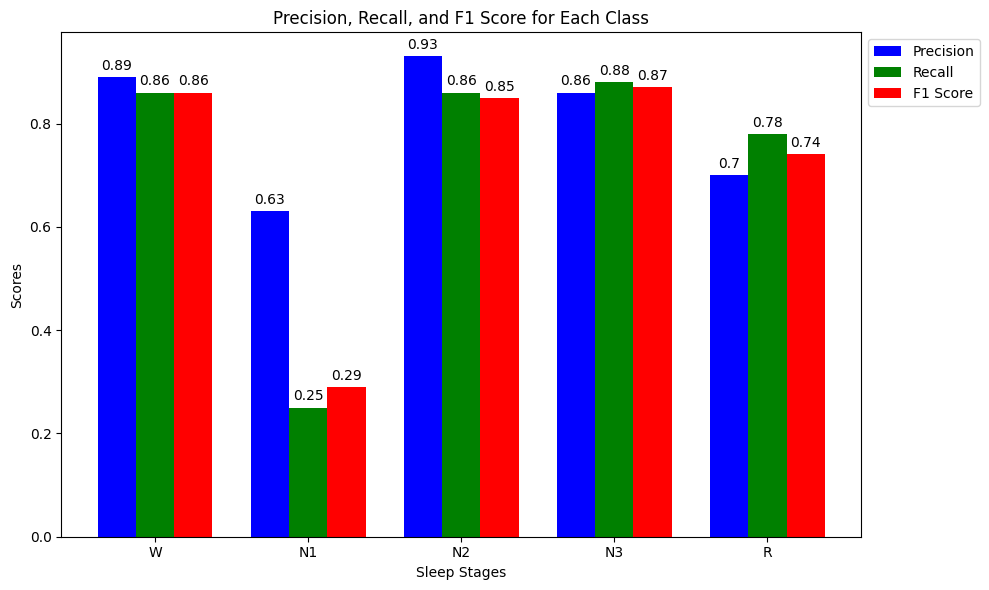

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Extracted values from your data
classes = ['W','N1','N2','N3','R']
precision = [0.89, 0.63, 0.93, 0.86, 0.70]
recall = [0.86, 0.25, 0.86, 0.88, 0.78]
f1_score = [0.86, 0.29, 0.85, 0.87, 0.74]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
index = np.arange(len(classes))

# Plot bars for each metric
bar1 = ax.bar(index, precision, bar_width, label='Precision', color='b')
bar2 = ax.bar(index + bar_width, recall, bar_width, label='Recall', color='g')
bar3 = ax.bar(index + 2*bar_width, f1_score, bar_width, label='F1 Score', color='r')

# Add aesthetics
ax.set_xlabel('Sleep Stages')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score for Each Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classes)

# Change legend location to right outside the chart
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

# Helper function to attach a text label above each bar
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)

plt.tight_layout()
plt.show()
